## 影评分析

In [1]:
# bs4:处理特殊符号。nltk:自然语言处理库。gensim:构建word2vec模型
import os
import re
import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### 用pandas读入训练数据

In [2]:
df = pd.read_csv('./data/labeledTrainData.tsv', sep='\t', escapechar='\\')
print('Number of reviews: {}'.format(len(df)))
df.head()

Number of reviews: 25000


,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


### 对影评数据做预处理，大概有以下环节：

1. 去掉html标签(bs4)
1. 移除标点
1. 切分成词/token
1. 去掉停用词
1. 重组为新的句子

In [3]:
df['review'][1000]

"I watched this movie really late last night and usually if it's late then I'm pretty forgiving of movies. Although I tried, I just could not stand this movie at all, it kept getting worse and worse as the movie went on. Although I know it's suppose to be a comedy but I didn't find it very funny. It was also an especially unrealistic, and jaded portrayal of rural life. In case this is what any of you think country life is like, it's definitely not. I do have to agree that some of the guy cast members were cute, but the french guy was really fake. I do have to agree that it tried to have a good lesson in the story, but overall my recommendation is that no one over 8 watch it, it's just too annoying."

In [4]:
# 去掉HTML标签的数据
example = BeautifulSoup(df['review'][1000], 'html.parser').get_text()
example

"I watched this movie really late last night and usually if it's late then I'm pretty forgiving of movies. Although I tried, I just could not stand this movie at all, it kept getting worse and worse as the movie went on. Although I know it's suppose to be a comedy but I didn't find it very funny. It was also an especially unrealistic, and jaded portrayal of rural life. In case this is what any of you think country life is like, it's definitely not. I do have to agree that some of the guy cast members were cute, but the french guy was really fake. I do have to agree that it tried to have a good lesson in the story, but overall my recommendation is that no one over 8 watch it, it's just too annoying."

In [5]:
# 去掉标点符号
example_letters = re.sub(r'[^a-zA-Z]', ' ', example)
example_letters

'I watched this movie really late last night and usually if it s late then I m pretty forgiving of movies  Although I tried  I just could not stand this movie at all  it kept getting worse and worse as the movie went on  Although I know it s suppose to be a comedy but I didn t find it very funny  It was also an especially unrealistic  and jaded portrayal of rural life  In case this is what any of you think country life is like  it s definitely not  I do have to agree that some of the guy cast members were cute  but the french guy was really fake  I do have to agree that it tried to have a good lesson in the story  but overall my recommendation is that no one over   watch it  it s just too annoying '

In [6]:
# 转成小写，切分
words = example_letters.lower().split()
words

['i',
 'watched',
 'this',
 'movie',
 'really',
 'late',
 'last',
 'night',
 'and',
 'usually',
 'if',
 'it',
 's',
 'late',
 'then',
 'i',
 'm',
 'pretty',
 'forgiving',
 'of',
 'movies',
 'although',
 'i',
 'tried',
 'i',
 'just',
 'could',
 'not',
 'stand',
 'this',
 'movie',
 'at',
 'all',
 'it',
 'kept',
 'getting',
 'worse',
 'and',
 'worse',
 'as',
 'the',
 'movie',
 'went',
 'on',
 'although',
 'i',
 'know',
 'it',
 's',
 'suppose',
 'to',
 'be',
 'a',
 'comedy',
 'but',
 'i',
 'didn',
 't',
 'find',
 'it',
 'very',
 'funny',
 'it',
 'was',
 'also',
 'an',
 'especially',
 'unrealistic',
 'and',
 'jaded',
 'portrayal',
 'of',
 'rural',
 'life',
 'in',
 'case',
 'this',
 'is',
 'what',
 'any',
 'of',
 'you',
 'think',
 'country',
 'life',
 'is',
 'like',
 'it',
 's',
 'definitely',
 'not',
 'i',
 'do',
 'have',
 'to',
 'agree',
 'that',
 'some',
 'of',
 'the',
 'guy',
 'cast',
 'members',
 'were',
 'cute',
 'but',
 'the',
 'french',
 'guy',
 'was',
 'really',
 'fake',
 'i',
 'do'

In [7]:
# 下载停用词和其他语料会用到
# nltk.download()

In [7]:
# 清理停用词
stopwords = {}.fromkeys([ line.rstrip() for line in open('./stopwords.txt')])
words_nostop = [w for w in words if w not in stopwords]
words_nostop

['watched',
 'movie',
 'late',
 'night',
 'late',
 'pretty',
 'forgiving',
 'movies',
 'stand',
 'movie',
 'worse',
 'worse',
 'movie',
 'suppose',
 'comedy',
 'didn',
 'funny',
 'unrealistic',
 'jaded',
 'portrayal',
 'rural',
 'life',
 'country',
 'life',
 'agree',
 'guy',
 'cast',
 'cute',
 'french',
 'guy',
 'fake',
 'agree',
 'lesson',
 'story',
 'recommendation',
 'watch',
 'annoying']

In [8]:
# 写到一起
eng_stopwords = set(stopwords)

def clean_text(text):
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    words = [w for w in words if w not in eng_stopwords]
    return ' '.join(words)

In [9]:
df['review'][1000]

"I watched this movie really late last night and usually if it's late then I'm pretty forgiving of movies. Although I tried, I just could not stand this movie at all, it kept getting worse and worse as the movie went on. Although I know it's suppose to be a comedy but I didn't find it very funny. It was also an especially unrealistic, and jaded portrayal of rural life. In case this is what any of you think country life is like, it's definitely not. I do have to agree that some of the guy cast members were cute, but the french guy was really fake. I do have to agree that it tried to have a good lesson in the story, but overall my recommendation is that no one over 8 watch it, it's just too annoying."

In [10]:
clean_text(df['review'][1000])

'watched movie late night late pretty forgiving movies stand movie worse worse movie suppose comedy didn funny unrealistic jaded portrayal rural life country life agree guy cast cute french guy fake agree lesson story recommendation watch annoying'

### 清洗数据添加到dataframe里

In [11]:
df['clean_review'] = df.review.apply(clean_text)
df.head()

,id,sentiment,review,clean_review
0,5814_8,1,With all this stuff going down at the moment w...,stuff moment mj ve started listening music wat...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin...",classic war worlds timothy hines entertaining ...
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,film starts manager nicholas bell investors ro...
3,3630_4,0,It must be assumed that those who praised this...,assumed praised film filmed opera didn read do...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,superbly trashy wondrously unpretentious explo...


### 抽取bag of words特征(用sklearn的CountVectorizer)

使用词频建模

In [12]:
# 选中5000条，生成向量，建模
vectorizer = CountVectorizer(max_features = 5000)
# 训练
train_data_features = vectorizer.fit_transform(df.clean_review).toarray()
train_data_features.shape

(25000, 5000)

In [15]:
# 交叉验证
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data_features,df.sentiment,test_size = 0.2, random_state = 0)

In [19]:
import matplotlib.pyplot as plt
import itertools
# 画一个混淆矩阵
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### 训练分类器

C:\Users\jarod\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Recall metric in the testing dataset:  0.8499184339314845
accuracy metric in the testing dataset:  0.8446


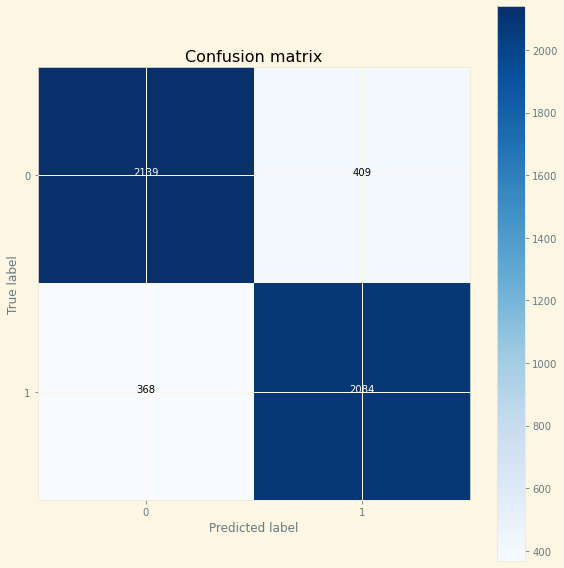

In [28]:
# 逻辑回归
LR_model = LogisticRegression()
LR_model = LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=[8,8])
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.style.use('Solarize_Light2')
plt.show()

In [30]:
df = pd.read_csv('./data/unlabeledTrainData.tsv', sep='\t', escapechar='\\')
print('Number of reviews: {}'.format(len(df)))
df.head()

Number of reviews: 50000


,id,review
0,9999_0,"Watching Time Chasers, it obvious that it was ..."
1,45057_0,I saw this film about 20 years ago and remembe...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba..."
3,7161_0,I went to see this film with a great deal of e...
4,43971_0,"Yes, I agree with everyone on this site this m..."


In [31]:
df['clean_review'] = df.review.apply(clean_text)
df.head()

,id,review,clean_review
0,9999_0,"Watching Time Chasers, it obvious that it was ...",watching time chasers obvious bunch friends si...
1,45057_0,I saw this film about 20 years ago and remembe...,film ago remember nasty based true incident br...
2,15561_0,"Minor Spoilers<br /><br />In New York, Joan Ba...",minor spoilersin york joan barnard elvire audr...
3,7161_0,I went to see this film with a great deal of e...,film deal excitement school director friend mi...
4,43971_0,"Yes, I agree with everyone on this site this m...",agree site movie bad call movie insult movies ...


In [32]:
review_part = df['clean_review']
review_part.shape

(50000,)

In [33]:
import warnings
warnings.filterwarnings("ignore")
# 调用英文分词模块
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

def split_sentences(review):
    # 分词
    raw_sentences = tokenizer.tokenize(review.strip())
    # 清洗
    sentences = [clean_text(s) for s in raw_sentences if s]
    return sentences
sentences = sum(review_part.apply(split_sentences), [])
print('{} reviews -> {} sentences'.format(len(review_part), len(sentences)))

50000 reviews -> 50000 sentences


In [34]:
sentences[0]

'watching time chasers obvious bunch friends sitting day film school hey pool money bad movie bad movie dull story bad script lame acting poor cinematography bottom barrel stock music corners cut prevented film release life'

In [35]:
# 转换成list
sentences_list = []
for line in sentences:
    sentences_list.append(nltk.word_tokenize(line))

-  sentences：可以是一个list
-  sg： 用于设置训练算法，默认为0，对应CBOW算法；sg=1则采用skip-gram算法。
-  size：是指特征向量的维度，默认为100。大的size需要更多的训练数据,但是效果会更好. 推荐值为几十到几百。
-  window：表示当前词与预测词在一个句子中的最大距离是多少
-  alpha: 是学习速率
-  seed：用于随机数发生器。与初始化词向量有关。
-  min_count: 可以对字典做截断. 词频少于min_count次数的单词会被丢弃掉, 默认值为5
-  max_vocab_size: 设置词向量构建期间的RAM限制。如果所有独立单词个数超过这个，则就消除掉其中最不频繁的一个。每一千万个单词需要大约1GB的RAM。设置成None则没有限制。

-  workers参数控制训练的并行数。
-  hs: 如果为1则会采用hierarchica·softmax技巧。如果设置为0（defau·t），则negative sampling会被使用。
-  negative: 如果>0,则会采用negativesamp·ing，用于设置多少个noise words
-  iter： 迭代次数，默认为5

In [36]:
# 设定词向量训练的参数
num_features = 300    # Word vector dimensionality
min_word_count = 40   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
model_name = '{}features_{}minwords_{}context.model'.format(num_features, min_word_count, context)

In [40]:
from gensim.models.word2vec import Word2Vec
model = Word2Vec(sentences_list, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
# 官网推荐的方式
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model.save(os.path.join('.', 'models', model_name))

In [41]:
# 举例：选出最不相关的词
print(model.doesnt_match(['man','woman','child','kitchen']))

kitchen


In [51]:
model.most_similar("boy")

[('girl', 0.6869118213653564),
 ('astro', 0.6643796563148499),
 ('angus', 0.6199091672897339),
 ('teenage', 0.6147064566612244),
 ('dad', 0.6096466779708862),
 ('brat', 0.6069021224975586),
 ('orphan', 0.6045187711715698),
 ('kid', 0.6040098667144775),
 ('teenager', 0.5937743186950684),
 ('bullies', 0.5841520428657532)]

In [43]:
model.most_similar("bad")

[('worse', 0.7284320592880249),
 ('horrible', 0.7036554217338562),
 ('terrible', 0.6961207985877991),
 ('crappy', 0.6693331003189087),
 ('lousy', 0.6650912761688232),
 ('awful', 0.6586936116218567),
 ('sucks', 0.640222430229187),
 ('atrocious', 0.6364172101020813),
 ('sucked', 0.6247537136077881),
 ('abysmal', 0.6114804744720459)]

In [45]:
df = pd.read_csv('./data/labeledTrainData.tsv', sep='\t', escapechar='\\')
df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"""The Classic War of the Worlds"" by Timothy Hin..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [52]:
from nltk.corpus import stopwords
eng_stopwords = set(stopwords.words('english'))
# 清洗
def clean_text(text, remove_stopwords=False):
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.lower().split()
    if remove_stopwords:
        words = [w for w in words if w not in eng_stopwords]
    return words

def to_review_vector(review):
    global word_vec
    
    review = clean_text(review, remove_stopwords=True)
    # print (review)
    # words = nltk.word_tokenize(review)
    word_vec = np.zeros((1,300))
    for word in review:
        # word_vec = np.zeros((1,300))
        # 先求和
        if word in model:
            word_vec += np.array([model[word]])
    # print (word_vec.mean(axis = 0))
    # 得出平均向量
    return pd.Series(word_vec.mean(axis = 0))

train_data_features = df.review.apply(to_review_vector)
train_data_features.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-1.202729,0.344530,-1.321862,-0.789175,-1.798110,-0.786647,1.746265,2.227394,-0.728191,-2.913282,...,0.657130,0.955116,-0.838360,-1.259888,-1.415311,1.506292,0.111640,-3.563608,-4.256406,-1.775520
1,0.931386,0.892859,-0.514565,1.962121,-0.762555,-1.274766,0.112161,2.057233,-0.793203,0.377169,...,1.446804,0.760788,-0.241946,-1.447952,-0.110455,-0.508363,1.262352,-2.572264,-1.744720,-2.232671
2,-3.473215,0.731399,-0.416883,-3.706338,1.960009,-0.996822,1.386367,0.597547,1.204848,-0.599759,...,0.119009,1.665437,-1.403070,-1.650885,-1.527953,2.059413,-2.913691,-0.423679,0.551560,-1.189734
3,1.535748,1.751412,-1.046448,0.495421,-0.463871,-2.532738,0.384694,-1.098423,1.154795,-1.419770,...,0.865475,1.301352,-0.646546,-2.528935,0.562761,1.302369,-1.220250,-3.896551,-1.637370,-2.231297
4,-3.296372,1.103326,-1.451988,-2.714159,-0.429610,0.648427,1.395672,-0.052388,1.123850,-2.686497,...,-0.811299,0.263551,0.950488,-1.068156,-0.849177,1.202361,-2.347493,-1.393772,-2.339532,-0.719538


In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data_features,df.sentiment,test_size = 0.2, random_state = 0)

Recall metric in the testing dataset:  0.8772430668841762
accuracy metric in the testing dataset:  0.8664


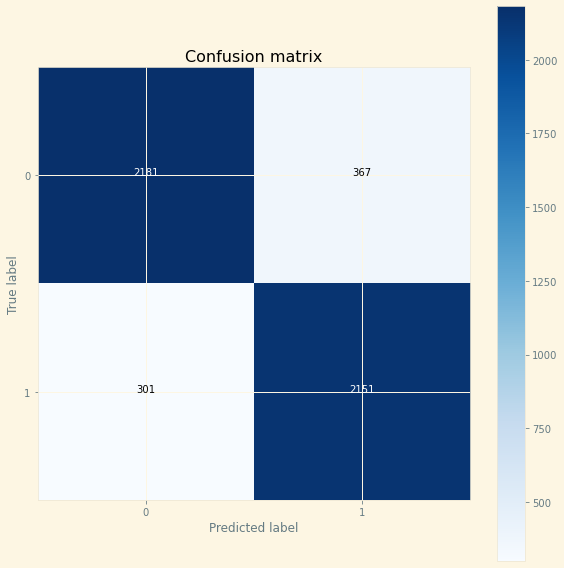

In [54]:
LR_model = LogisticRegression()
LR_model = LR_model.fit(X_train, y_train)
y_pred = LR_model.predict(X_test)
cnf_matrix = confusion_matrix(y_test,y_pred)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

print("accuracy metric in the testing dataset: ", (cnf_matrix[1,1]+cnf_matrix[0,0])/(cnf_matrix[0,0]+cnf_matrix[1,1]+cnf_matrix[1,0]+cnf_matrix[0,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=[8,8])
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.style.use('Solarize_Light2')
plt.show()